# Weather prediction - time series
- Climate dataset from [ Max Planck Institute](https://www.bgc-jena.mpg.de/wetter/)
- Baseline from [keras](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)
- [Open in Colab](https://drive.google.com/file/d/15jaSG9xdD02dSPKs74LuQ-zmc68pV6-I/view?usp=sharing)

In [ ]:
!pip install tfts
# !pip install -U git+https://github.com/LongxingTan/Time-series-prediction.git --quiet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tfts import AutoConfig, AutoModel, KerasTrainer
import yfinance as yf
import pandas_ta as ta

## EDA

In [98]:
def download(symbol, start, end, interval='1d'):
    df = yf.download(symbol, start=start, end=end, interval=interval)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df


df = download("AAPL", "2000-01-01", "2025-04-08")

df_original = df.copy()
df['vol_ratio'] = (df['Volume'].rolling(5).mean()) / (df['Volume'].rolling(10).mean()) - 1

df['sma_5']= ta.sma(df.Close, 5)
df['sma_10']= ta.sma(df.Close, 10)
#df['ema_5']= ta.ema(df.Close, 5)
#df['ema_10']= ta.ema(df.Close, 10)
macd_df = ta.macd(df.Close, 12, 26, 9, col_names=('macd', 'macd_signal', 'macd_diff'))
macd_df.columns = ['macd', 'macd_signal', 'macd_diff']
df['macd'] = macd_df['macd']
df['macd_signal'] = macd_df['macd_signal']
df['macd_diff'] = macd_df['macd_diff']

df['RSI_14'] = ta.rsi(df['Close'], timeperiod=14) 
df_bbands  =ta.bbands(df['Close'])

df_bbands.columns = ['BB_lower', 'BB_middle', 'BB_upper', 'BB_width', 'BB_percent']
df['BB_upper'] = df_bbands['BB_upper']
df['BB_middle'] = df_bbands['BB_middle']
df['BB_lower'] = df_bbands['BB_lower']

df['MFI'] = df.ta.mfi(length=14)
df['OBV'] = df.ta.obv(close=df['Close'], volume=df['Volume'])



df['future_ret_1d'] = df['Close'].pct_change().shift(-1)
#df['future_1d'] = df['Close'].shift(-1)

df['DateTime'] =df.index
df.drop(columns=['Volume'], inplace=True)
date_time_key = "DateTime"

df.dropna(inplace=True)
#print(df.tail(10))

[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_155978/1538202448.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.19842245e+08 7.45852532e+08 2.95714560e+08 ... 1.44524763e+10
 8.08082763e+09 8.02018127e+09]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['MFI'] = df.ta.mfi(length=14)
/tmp/ipykernel_155978/1538202448.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.03872930e+08 5.71998550e+08 3.42007270e+08 ... 2.10950632e+10
 2.41581049e+10 2.94311239e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['MFI'] = df.ta.mfi(length=14)


feature_keys: ['Close', 'High', 'Low', 'Open', 'vol_ratio', 'sma_5', 'sma_10', 'macd', 'macd_signal', 'macd_diff', 'RSI_14', 'BB_upper', 'BB_middle', 'BB_lower', 'MFI', 'OBV', 'future_ret_1d']


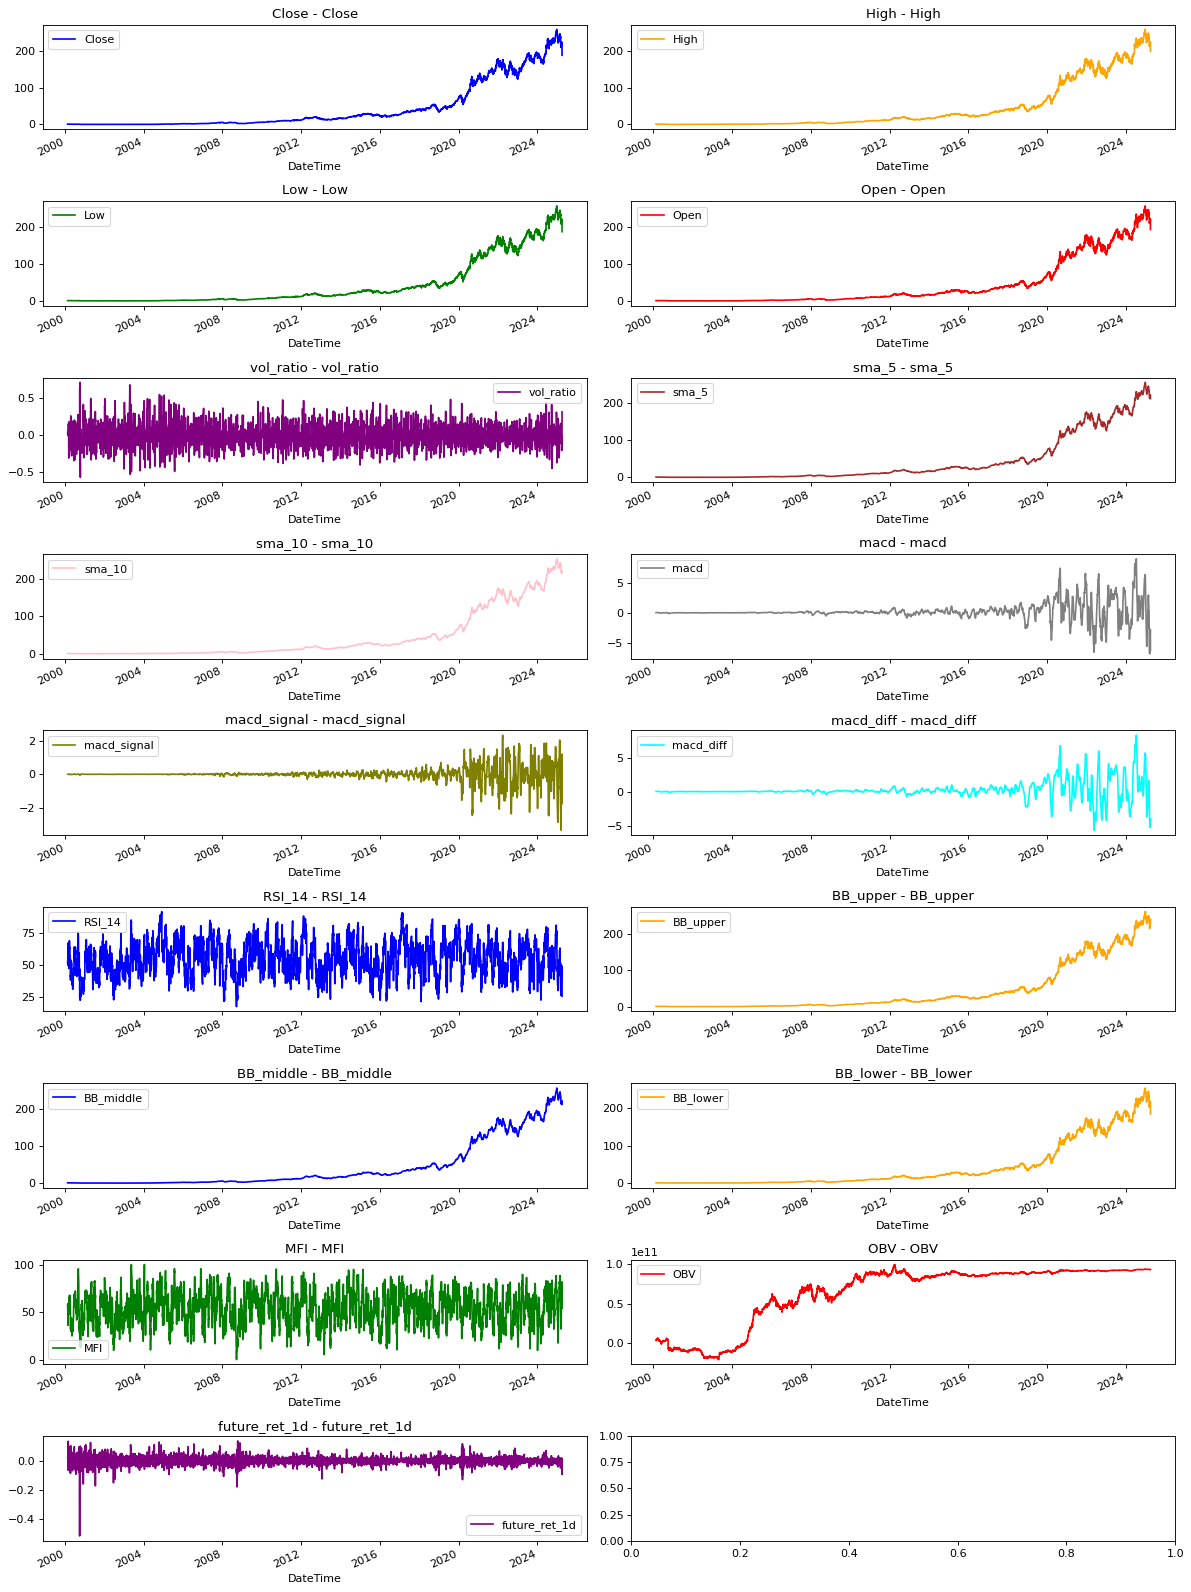

In [99]:

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "blue",
    "orange",
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
]
titles =df.columns.tolist()
titles.remove(date_time_key)


feature_keys = titles
print('feature_keys:',feature_keys)



def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Data preparation

In [102]:
#split_fraction = 0.715
split_fraction = 0.9
train_split = int(split_fraction * int(df.shape[0]))
step = 3

past = 34
future = 2
learning_rate = 0.0005
batch_size = 64
epochs = 125


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


print(
    "The selected parameters are:",
    titles, 
)

selected_features =feature_keys
print("The selected features are:", ", ".join(selected_features))
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(selected_features)-1)]].values
y_train = features.iloc[start:end][[len(selected_features)-1]]

print(x_train.shape)
print(y_train.shape)

sequence_length = int(past / step)


dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


# valid
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(selected_features)-1)]].values
y_val = features.iloc[label_start:][[len(selected_features)-1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

The selected parameters are: ['Close', 'High', 'Low', 'Open', 'vol_ratio', 'sma_5', 'sma_10', 'macd', 'macd_signal', 'macd_diff', 'RSI_14', 'BB_upper', 'BB_middle', 'BB_lower', 'MFI', 'OBV', 'future_ret_1d']
The selected features are: Close, High, Low, Open, vol_ratio, sma_5, sma_10, macd, macd_signal, macd_diff, RSI_14, BB_upper, BB_middle, BB_lower, MFI, OBV, future_ret_1d
(5688, 16)
(5688, 1)
Input shape: (64, 11, 16)
Target shape: (64, 1)


## Training

In [103]:
model_name_or_path = "rnn"
config = AutoConfig.for_model(model_name_or_path)
config.rnn_type = "lstm"
print(config)

model = AutoModel.from_config(config, predict_sequence_length=1)

{'rnn_hidden_size': 64, 'rnn_type': 'lstm', 'bi_direction': False, 'dense_hidden_size': 128, 'num_stacked_layers': 1, 'scheduled_sampling': 0.0, 'use_attention': False}


In [104]:
%%time
opt = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()
trainer = KerasTrainer(model, loss_fn=loss_fn, optimizer=opt)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
'''
history = trainer.train(
    dataset_train, dataset_val, epochs=epochs, batch_size=batch_size, callbacks=[early_stop_callback]
)
'''
history = trainer.train(
    dataset_train, dataset_val, epochs=epochs, batch_size=batch_size
)

Epoch 1/125
 2/89 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.7090  

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_65']
Received: inputs=Tensor(shape=(64, 11, 16))
  warnings.warn(msg)


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.7710

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_65']
Received: inputs=Tensor(shape=(26, 11, 16))
  warnings.warn(msg)


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 1.7625 - val_loss: 0.4326
Epoch 2/125
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 3.2001

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_65']
Received: inputs=Tensor(shape=(54, 11, 16))
  warnings.warn(msg)


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1.7889 - val_loss: 0.6672
Epoch 3/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.7865 - val_loss: 0.5958
Epoch 4/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.7431 - val_loss: 0.3499
Epoch 5/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.7498 - val_loss: 0.3612
Epoch 6/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.7395 - val_loss: 0.3675
Epoch 7/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 1.7350 - val_loss: 0.3567
Epoch 8/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.7348 - val_loss: 0.3416
Epoch 9/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 1.7331 - val_loss: 0.3655
Epoch 10/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.7287 - val_loss: 0.3438
Epoch 11/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.7310 - val_loss: 0.3324
Epoch 12/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.7325 - val_loss: 0.3446
Epoch 13/125
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1.

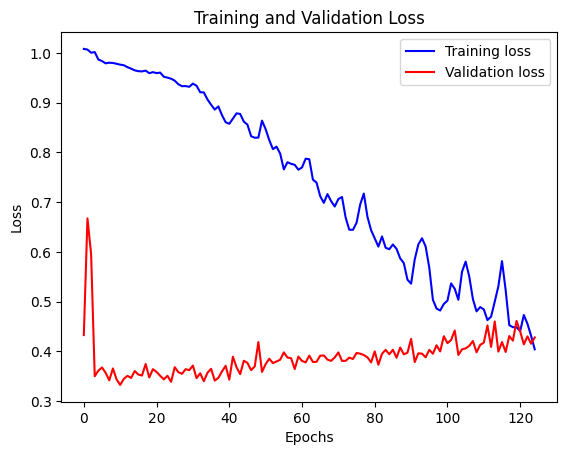

In [105]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Evaluation

## Testing

len(dataset_val) =  9
tf.Tensor([[0.2001873]], shape=(1, 1), dtype=float32)


/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_65']
Received: inputs=Tensor(shape=(1, 11, 16))
  warnings.warn(msg)


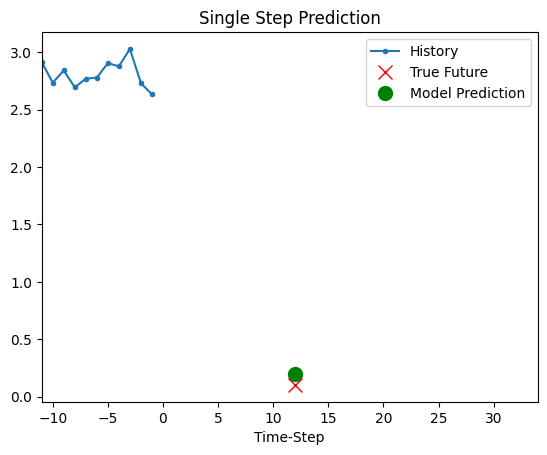

tf.Tensor([[0.17096087]], shape=(1, 1), dtype=float32)


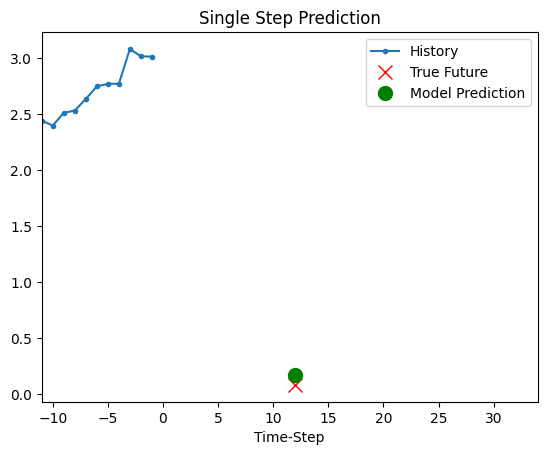

tf.Tensor([[-0.17518635]], shape=(1, 1), dtype=float32)


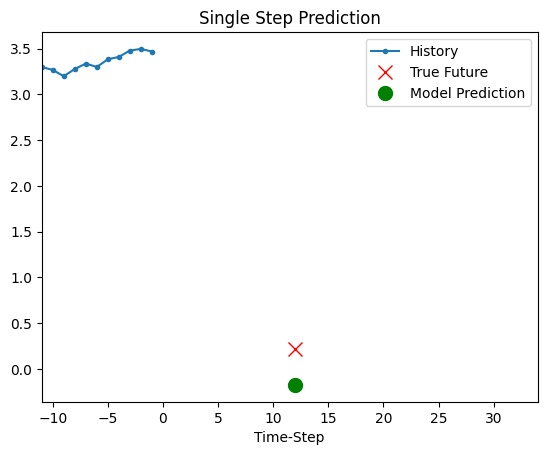

tf.Tensor([[0.29486424]], shape=(1, 1), dtype=float32)


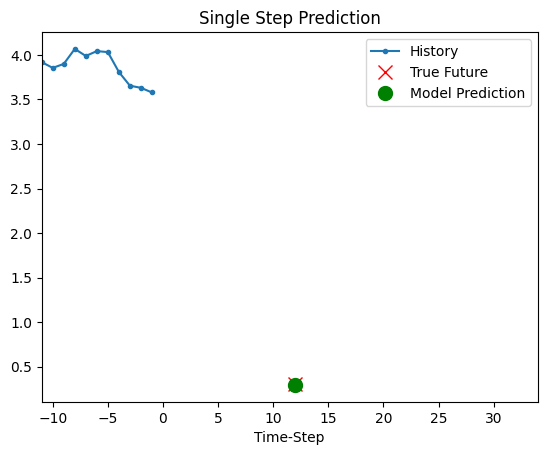

tf.Tensor([[0.1505484]], shape=(1, 1), dtype=float32)


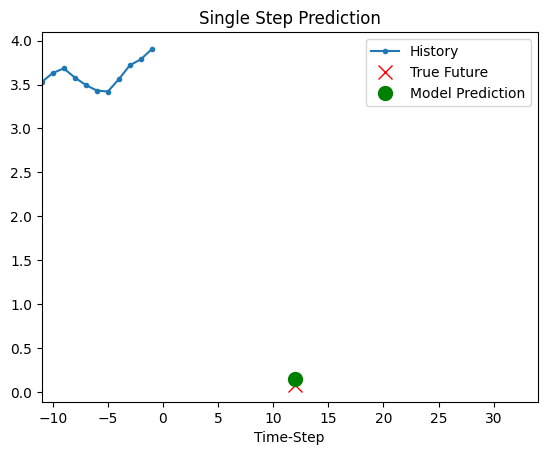

In [106]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

print('len(dataset_val) = ', len(dataset_val))
for x, y in dataset_val.take(5):
    print (model.model(x[:1])[0])
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.model(x[:1])[0]],
        12,
        "Single Step Prediction",
    )



In [115]:
model.model.save_weights("./weights/appl_day_model.weights.h5")